# Predicting COVID-19 Hospital Patient Length of Stay using Random Forest

### Synopsis & Background

* As the COVID-19 pandemic spikes, determining the needs for healthcare resources (beds, staff, equipment) has become a key priority for many countries. Projecting future demand requires estimates of how long patients with COVID-19 need different levels of hospital care.

* The patient length of stay is one of the critical parameters to observe and predict if an improvement to the efficiency of the healthcare management in a hospital is to be made. This parameter helps hospitals to identify patients of a high length of stay risk (patients who will stay longer) at the time of admission. 

* Once identified, prior knowledge of the length of stay of the patient being admitted can aid in logistics such as room, bed allocation, staff assignment, and PPE (Personal Protective Equipment) consumption planning. The problem is to manage the functioning of Hospitals professionally and optimally.

* Python is used as a tool of choice for the EDA and model development. In addition, the workstation, or the environment where the Random Forest models are fit & tuned is also important, since lack of processing resources could impediment fitting decently accurate models, especially when the random forest model needs to be hyper-tuned. 

* While some analysis of data is done locally on a workstation, to address this resource shortage on local workstations, the Azure ML node is utilized to fit & tune the models and perform most of the analysis. 

* The Azure ML node used, also known as a “Compute”, has a configuration of 56GB RAM, 6 cores CPU, 1 GPU, and 380GB disk space.

### Hypothesis of Study:
#### Null Hypothesis: 
The null hypothesis is that a random forest classification model cannot predict probabilities for target length of stay with 11 classes correctly i.e., the mean ROC-AUC score from Repeated Stratified K Fold Cross-Validation for random forest model on the validation data set is not more than 50%.

#### Alternate Hypothesis: 
An alternative hypothesis to the null hypothesis is that the random forest classification model predicts the probabilities for target length of stay classes and correctly distinguishes between the classes, i.e., the mean ROC-AUC score from Repeated Stratified K Fold Cross-Validation for random forest model on the validation data set is significantly greater than 50%. If the mean AUC score is more than 50%, then the Random Forest model offers a better intuition to manage the hospital resources optimally and it justifies implementing this complex solution.


In [1]:
# For each new instance of compute, to prepare the environment install these pacakges only once!
# Restart the kernel after installing these

# !pip3 install seaborn
# !pip3 install delayed
# !pip3 install imblearn
# !pip3 install pingouin

     |████████████████████████████████| 206 kB 6.4 MB/s eta 0:00:01
     |████████████████████████████████| 22.2 MB 8.3 MB/s eta 0:00:01
ERROR: raiwidgets 0.2.2 has requirement lightgbm>=3.1.1, but you'll have lightgbm 2.3.0 which is incompatible.
ERROR: azureml-train-automl-runtime 1.28.0 has requirement scikit-learn<0.23.0,>=0.19.0, but you'll have scikit-learn 0.24.2 which is incompatible.
ERROR: azureml-automl-runtime 1.28.0.post2 has requirement scikit-learn<0.23.0,>=0.19.0, but you'll have scikit-learn 0.24.2 which is incompatible.
ERROR: autokeras 1.0.13 has requirement tensorflow>=2.3.0, but you'll have tensorflow 2.1.0 which is incompatible.
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 205 kB 11.5 MB/s eta 0:00:01
     |████████████████████████████████| 736 kB 17.6 MB/s eta 0:00:01
  Crea

# 1. Load Required Libraries, Load data in notebook and EDA

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318438 entries, 1 to 318438
Data columns (total 17 columns):
Hospital                             318438 non-null int64
Hospital_type                        318438 non-null int64
Hospital_city                        318438 non-null int64
Hospital_region                      318438 non-null int64
Available_Extra_Rooms_in_Hospital    318438 non-null int64
Department                           318438 non-null object
Ward_Type                            318438 non-null object
Ward_Facility                        318438 non-null object
Bed_Grade                            318325 non-null float64
patientid                            318438 non-null int64
City_Code_Patient                    313906 non-null float64
Type of Admission                    318438 non-null object
Illness_Severity                     318438 non-null object
Patient_Visitors                     318438 non-null int64
Age                                  318438 non-null o

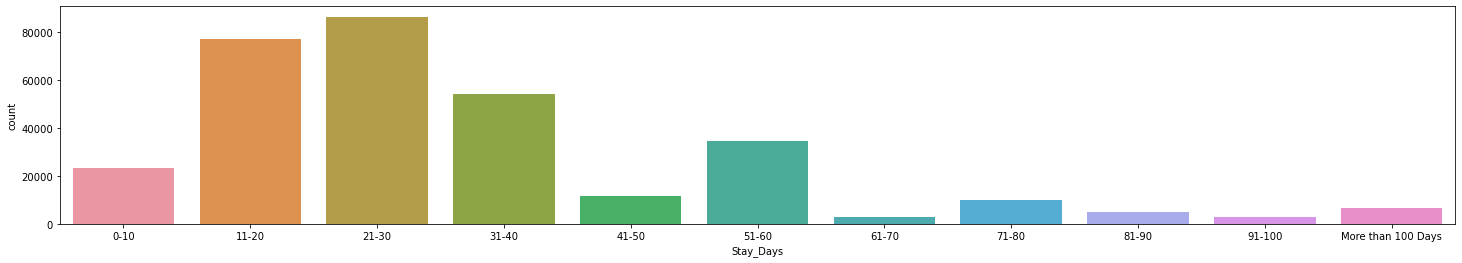

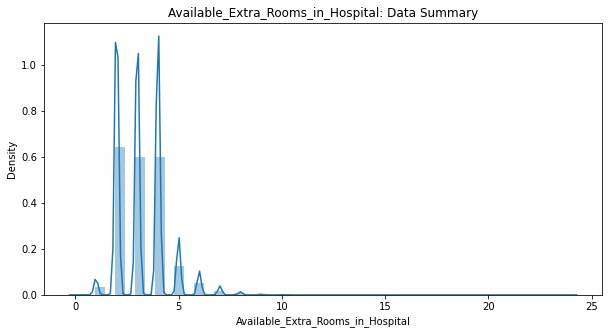

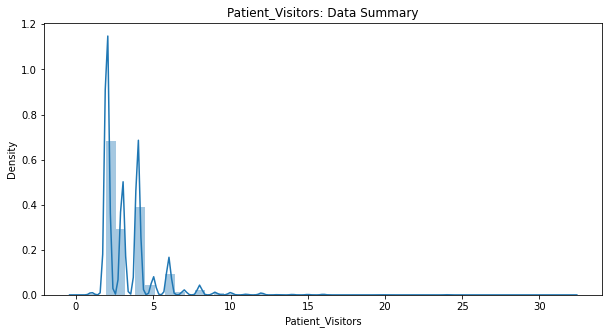

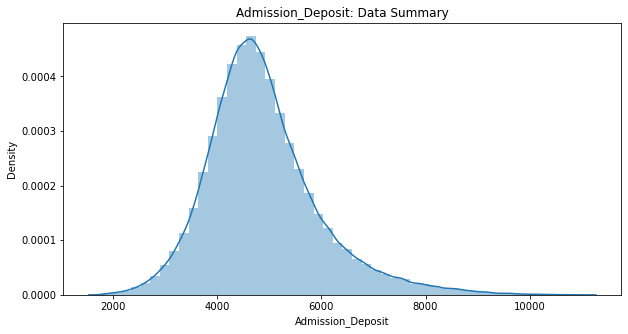

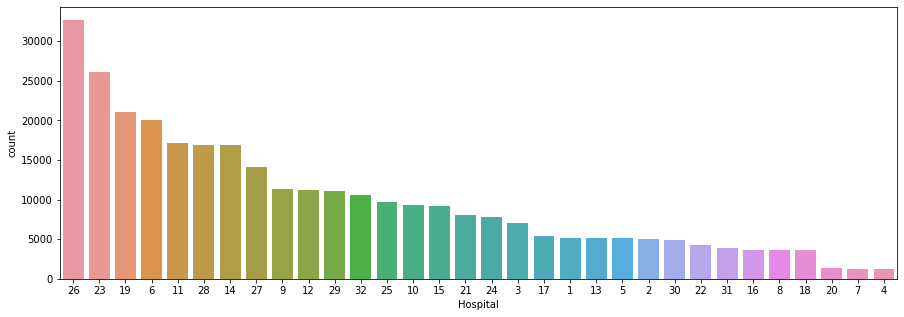

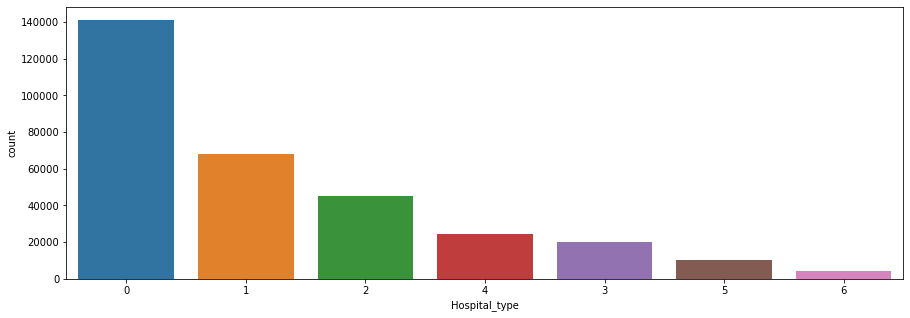

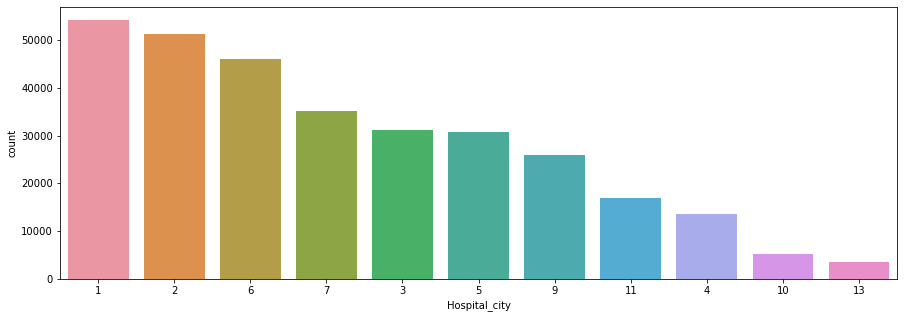

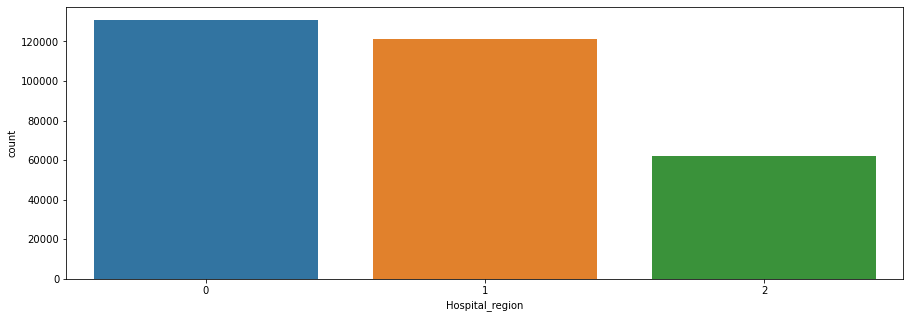

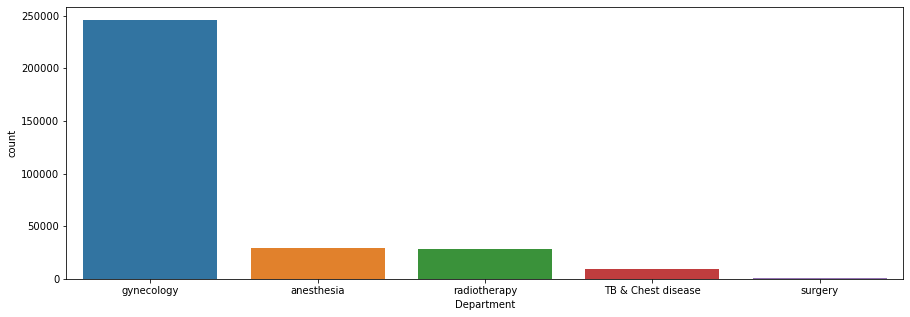

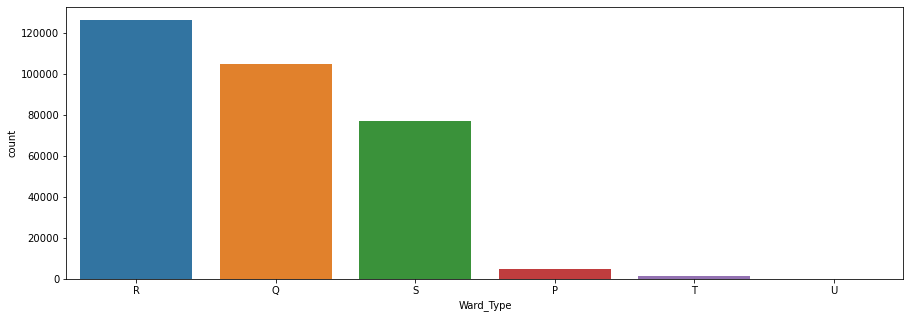

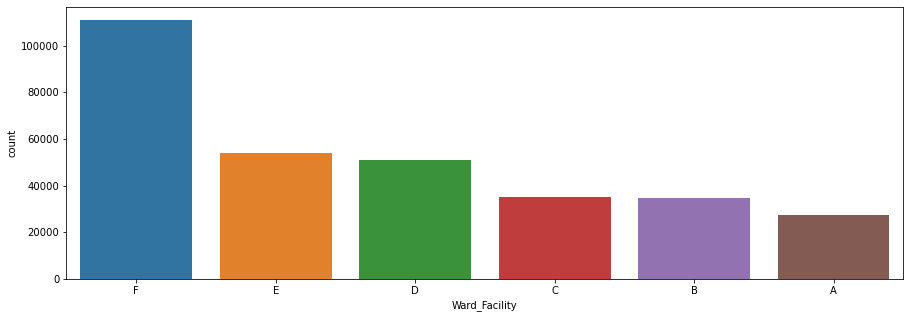

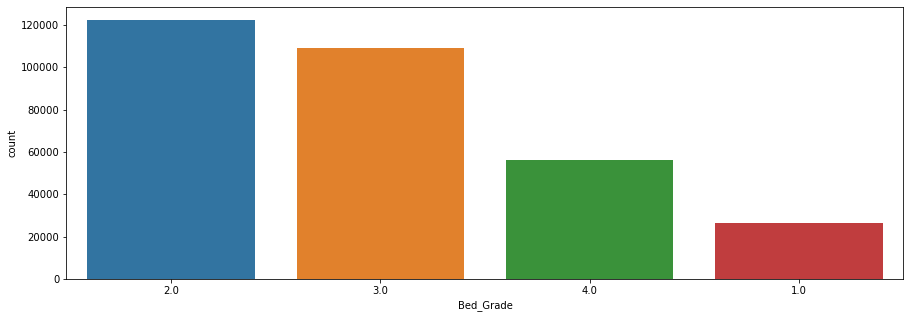

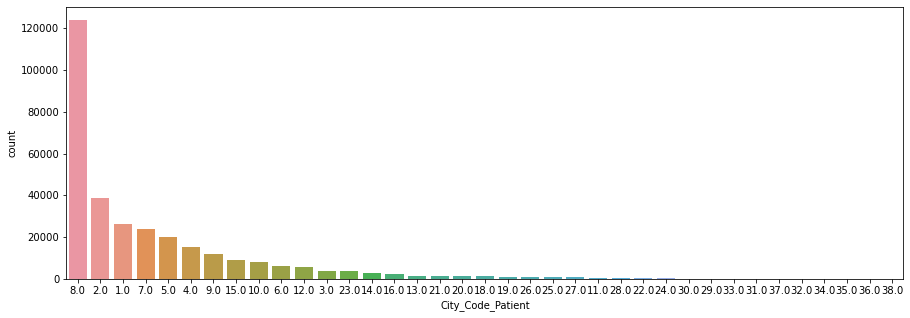

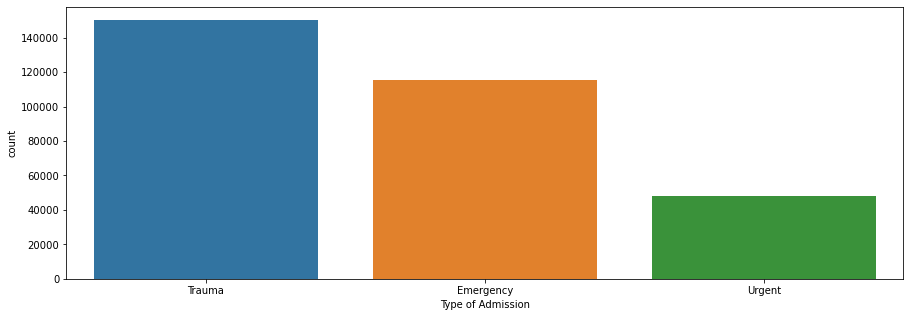

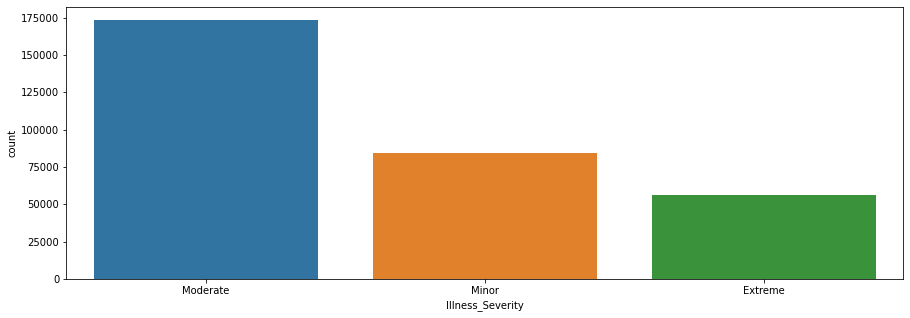

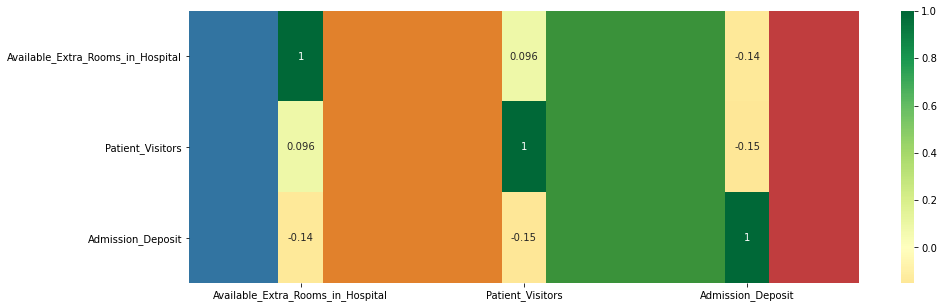

In [2]:
# +
import pandas as pd
import numpy as np
from pandas import read_csv
from numpy import mean
from numpy import std
from numpy import mean
from numpy import std
import warnings
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# from sklearn.metrics import classification_report, roc_auc_score,roc_curve, precision_recall_curve, recall_score, precision_score, f1_score, log_loss
import sklearn.metrics as metrics
from imblearn.over_sampling import SMOTE

from imblearn import under_sampling, over_sampling
from azureml.core.run import Run

pd.set_option('display.max_columns', 999)
pd.set_option("display.max_rows", 500)
warnings.simplefilter(action='ignore', category=FutureWarning)

### To read data in Azure ML Cloud
from azureml.core import Workspace, Dataset
subscription_id = '1160d482-979f-478f-97bb-ff801e9cca86'
resource_group = 'WGU'
workspace_name = 'WGUCapstone'

# sklearn.externals.joblib is removed in 0.23
try:
    from sklearn.externals import joblib
except ImportError:
    import joblib

# +
workspace = Workspace(subscription_id, resource_group, workspace_name)

covid_df_raw = Dataset.get_by_name(workspace, name='covid_los_raw')
covid_df = covid_df_raw.to_pandas_dataframe()
df = covid_df.copy(deep=True)
# -

covid_df = covid_df.set_index(["case_id"])

############################################
# Temporarily Commenting for automated scripts
print(covid_df.info())
print(covid_df.isnull().sum())
############################################
# +
t_missing = covid_df.isnull().sum().sum()
t_count = covid_df.Stay_Days.count()
t_nonmissing = t_count - t_missing

print(f"Missing: Bed_Grade: {113/318438 :.2%} and City_Code_Patient: {4532/318438 :.2%}")
overall_sparsity = 1.0 - (t_nonmissing/t_count)
print(f"Overall Sparsity: {overall_sparsity :.2%} \n")
# -

# Drop rows with missing values - Adding this for scripts, remove from here later on!!!
# covid_df.dropna(inplace=True)

############################################
# Temporarily Commenting for automated scripts
print(f"Total Number of Unique Values: \n{covid_df.nunique()}")


print("List of Unique Values: \n")
for i in covid_df.columns.tolist():
  print(i, ": ", covid_df[i].unique())

# Drop rows with missing values
covid_df.dropna(inplace=True)
print(f"Rows with Missing values dropped. Total # of rows now {covid_df.Stay_Days.value_counts().sum()}")

# Check the distribution of Stay_Days Response Variable - Balanced or Imbalanced
plt.subplots(figsize=(25,4))
sns.countplot(x="Stay_Days", data=covid_df.sort_values(by=["Stay_Days"]))#, order=covid_df["Stay_Days"].value_counts().index)
############################################

# +
num_columns = ['Available_Extra_Rooms_in_Hospital', 'Patient_Visitors', 'Admission_Deposit']
cat_columns = [col for col in covid_df.columns if col not in (num_columns + ["Stay_Days"] + ["case_id"] + ["patientid"])]

############################################
# Temporarily Commenting for automated scripts

# Check the distribution of continuous features
for i in num_columns:
  plt.figure(figsize=(10,5))
  sns.distplot(covid_df[i], kde=True, hist=True).set_title(f"{i}: Data Summary")
# -

# Check the distribution of classes within categorical variables 
for col in cat_columns:
  plt.subplots(figsize=(15,5))
  sns.countplot(x=col, data=covid_df, order=covid_df[col].value_counts().index)

# Check correlations among continuous features
sns.heatmap(covid_df[num_columns].corr(), annot=True, center=0, cmap="RdYlGn")

# #### covid_df Feature Changes in 1 cell
#
############################################
# +




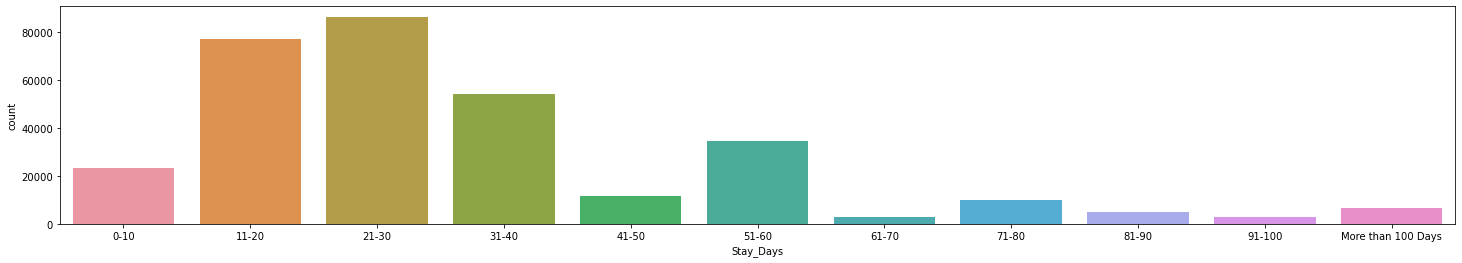

In [3]:
plt.subplots(figsize=(25,4))
sns.countplot(covid_df["Stay_Days"].sort_values())

# 2. Feature Engineering

In [4]:
def feature_engineering(covid_temp):
    ord_enc_y = OrdinalEncoder()
    ord_enc_Age = OrdinalEncoder()
    le_encode = LabelEncoder()

    # Encode Target Variable 
    covid_temp["Stay_Days"] = ord_enc_y.fit_transform(covid_temp[["Stay_Days"]]).astype("int32")

    ### Encode & Rename Independent Variables
    ### Hospital, Hospital_Type, Hospital_city, Hospital_region are already numeric encoded and dtype is "int"

    # Rename columns to remove spaces and shorten length
    covid_temp = covid_temp.rename(columns={"Available_Extra_Rooms_in_Hospital":"Extra_Rooms", 
                                            "Type of Admission":"Admission_Type"})
    # Encode Independent Variables
    covid_temp["Age"] = ord_enc_Age.fit_transform(covid_temp[["Age"]]).astype("int32")
    covid_temp["Ward_Type"] = le_encode.fit_transform(covid_temp[["Ward_Type"]]).astype("int32")
    covid_temp["Ward_Facility"] = le_encode.fit_transform(covid_temp[["Ward_Facility"]]).astype("int32")
    covid_temp["Department"] = le_encode.fit_transform(covid_temp[["Department"]]).astype("int32")
    covid_temp["Admission_Type"] = le_encode.fit_transform(covid_temp["Admission_Type"]).astype("int32")
    covid_temp["Illness_Severity"] = le_encode.fit_transform(covid_temp["Illness_Severity"]).astype("int32")
    covid_temp["Illness_Severity"] = le_encode.fit_transform(covid_temp["Illness_Severity"]).astype("int32")

    # Change data type of columns to integer from string
    covid_temp["Bed_Grade"] = covid_temp["Bed_Grade"].astype("int32")
    covid_temp["City_Code_Patient"] = covid_temp["City_Code_Patient"].astype("int32")
    covid_temp["patientid"] = covid_temp["patientid"].astype("int32")


    return covid_temp

covid_adj_df = feature_engineering(covid_df)
covid_adj_df.info()

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 313793 entries, 1 to 318438
Data columns (total 17 columns):
Hospital             313793 non-null int64
Hospital_type        313793 non-null int64
Hospital_city        313793 non-null int64
Hospital_region      313793 non-null int64
Extra_Rooms          313793 non-null int64
Department           313793 non-null int32
Ward_Type            313793 non-null int32
Ward_Facility        313793 non-null int32
Bed_Grade            313793 non-null int32
patientid            313793 non-null int32
City_Code_Patient    313793 non-null int32
Admission_Type       313793 non-null int32
Illness_Severity     313793 non-null int32
Patient_Visitors     313793 non-null int64
Age                  313793 non-null int32
Admission_Deposit    313793 non-null float64
Stay_Days            313793 non-null int32
dtypes: float64(1), int32(10), int64(6)
memory usage: 31.1 MB


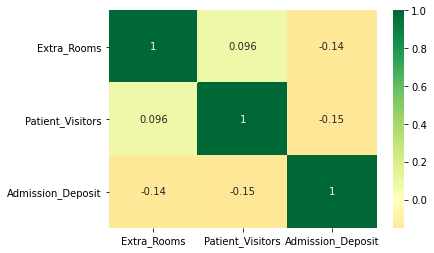

In [9]:
num_columns = ['Extra_Rooms', 'Patient_Visitors', 'Admission_Deposit']
sns.heatmap(covid_adj_df[num_columns].corr(), annot=True, center=0, cmap="RdYlGn")

In [11]:
covid_adj_df.head()

,Hospital,Hospital_type,Hospital_city,Hospital_region,Extra_Rooms,Department,Ward_Type,Ward_Facility,Bed_Grade,patientid,City_Code_Patient,Admission_Type,Illness_Severity,Patient_Visitors,Age,Admission_Deposit,Stay_Days
case_id,,,,,,,,,,,,,,,,,
1,8,2,3,2,3,3,2,5,2,31397,7,0,0,2,5,4911.0,0
2,2,2,5,2,2,3,3,5,2,31397,7,1,0,2,5,5954.0,4
3,10,4,1,0,2,1,3,4,2,31397,7,1,0,2,5,4745.0,3
4,26,1,2,1,2,3,2,3,2,31397,7,1,0,2,5,7272.0,4
5,26,1,2,1,2,3,3,3,2,31397,7,1,0,2,5,5558.0,4


# 3. Custom Function for plotting Multi-label ROC-AUC Curves

In [13]:
# Define function to plot ROC curve to contrast for all Response classes

def plot_multiclass_roc(title, y_score, y_test_dummies, n_classes, figsize=(17, 6)):
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
   # y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver operating characteristic - {title}')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

def predicted_scores(y_test_oh, y_pred_oh, y_test, y_pred, y_pred_prob, multi_class, average):
    accuracy = metrics.accuracy_score(y_true=y_test_oh, y_pred=y_pred_oh)
    print(f"Accuracy: {accuracy :.2%}")

    auc_score_pred_prob = metrics.roc_auc_score(y_true=y_test, y_score=y_pred_prob, multi_class=multi_class)
    print(f"AUC Score_Proba: {auc_score_pred_prob:.2%}")

    recall_scores = metrics.recall_score(y_true=y_test_oh, y_pred=y_pred_oh, average=average)
    print(f"Recall Score: {recall_scores :.2%}")

    precision_scores = metrics.precision_score(y_true=y_test_oh, y_pred=y_pred_oh, average=average)
    print(f"Precision Score: {precision_scores :.2%}")

    f1_scores = metrics.f1_score(y_true=y_test_oh, y_pred=y_pred_oh, average=average)
    print(f"F1 Score: {f1_scores :.2%}")

    return accuracy, auc_score_pred_prob, recall_scores, precision_scores, f1_scores


# 4. Perform Train-Test Split of the data set for Honest Assessment

In [14]:
# Perform Train-Test Split for the Original Data Set
train, test = train_test_split(covid_adj_df, random_state=123, train_size=0.8, test_size=0.2, shuffle=True)
X_train = train.drop(["Stay_Days"],axis=1) # Drop patientid if scores are very low and then try again
X_test = test.drop(["Stay_Days"],axis=1) # Drop patientid if scores are very low and then try again
y_train = train.Stay_Days
y_test = test.Stay_Days

In [15]:
len(X_train), len(y_train), len(X_test), len(y_test)

(251034, 251034, 62759, 62759)

# 5. Baseline Dummy Classifier Model with Cross-Validation score

In [16]:
from sklearn.utils import parallel_backend
dummy_clf = DummyClassifier(strategy="most_frequent")
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# Evaluate Dummy Classifier
print("\n For Dummy Baseline Model: \n")
print("Repeated Stratified K Fold - Cross Validation Scores: \n")

with parallel_backend('threading', n_jobs=4):
    dummy_score_rocaucovow = cross_val_score(dummy_clf, X_test, y_test, scoring="roc_auc_ovo_weighted", cv=cv)

print(f"Repeated Stratified Cross Validation Score for Dummy Baseline Model: {np.mean(dummy_score_rocaucovow) :.2%}")


 For Dummy Baseline Model: 

Repeated Stratified K Fold - Cross Validation Scores: 

Repeated Stratified Cross Validation Score for Dummy Baseline Model: 50.00%


# 6. Baseline Random Forest Classifier Model (with Default Parameters) & Cross-Validation score

In [17]:
# Establish a Baseline Random Forest Model 
from sklearn.utils import parallel_backend

rf_base = RandomForestClassifier(verbose=1)

with parallel_backend ("threading",n_jobs=-1):
    rf_base_model = rf_base.fit(X=X_train, y=y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.2s finished


In [18]:
y_pred_p = rf_base_model.predict_proba(X_test)
y_pred = rf_base_model.predict(X_test)

y_pred_oh = pd.get_dummies(y_pred)
y_test_oh = pd.get_dummies(y_test)

predicted_scores(y_pred=y_pred, 
                 y_test=y_test,
                 y_pred_prob = y_pred_p, 
                 y_test_oh=y_test_oh, 
                 y_pred_oh=y_pred_oh,
                 average="weighted", 
                 multi_class="ovo")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.1s finished


Accuracy: 40.24%
AUC Score_Proba: 76.22%
Recall Score: 40.24%
Precision Score: 38.86%
F1 Score: 37.91%


(0.40242833697158975,
 0.7622112731989186,
 0.40242833697158975,
 0.3886291076334977,
 0.3790824223803094)

In [19]:
x_cols = ['Hospital',
 'Hospital_type',
 'Hospital_city',
 'Hospital_region',
 'Extra_Rooms',
 'Department',
 'Ward_Type',
 'Ward_Facility',
 'Bed_Grade',
 'patientid',
 'City_Code_Patient',
 'Admission_Type',
 'Illness_Severity',
 'Patient_Visitors',
 'Age',
 'Admission_Deposit']

In [20]:
# Generate Repeated Stratified K Fold Cross Validation score for Base Random Forest model 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
with parallel_backend ("threading",n_jobs=-1):
    rfbase_score_rocaucovow = cross_val_score(rf_base, covid_adj_df[x_cols], covid_adj_df["Stay_Days"], scoring="roc_auc_ovo_weighted", cv=cv)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   55.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   55.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   56.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   56.2s 

In [21]:
print(f"Repeated Stratified Cross Validation Score for Base Random Forest Model is : {np.mean(rfbase_score_rocaucovow) :.2%} \n")

Repeated Stratified Cross Validation Score for Base Random Forest Model is : 77.09% 



## 6.1 Feature Importance

Important Features from Baseline Random Forest


,feature,importance
15,Admission_Deposit,0.201492
9,patientid,0.192407
14,Age,0.097572
10,City_Code_Patient,0.090102
13,Patient_Visitors,0.088861
4,Extra_Rooms,0.058014
0,Hospital,0.041745
8,Bed_Grade,0.040871
5,Department,0.036954
6,Ward_Type,0.036821


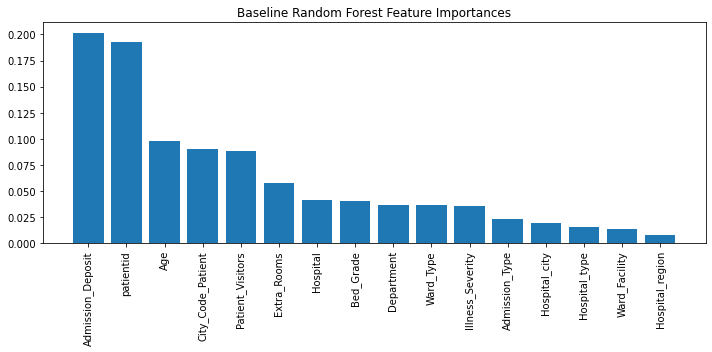

In [22]:
feature_importance_base = pd.DataFrame({"feature": list(X_train.columns),
                                    "importance":rf_base_model.feature_importances_}).sort_values("importance", ascending=False)
plt.figure(figsize=(10,5))
plt.bar(x="feature", height="importance", data=feature_importance_base)
plt.xticks(feature_importance_base["feature"].tolist(), rotation=90)
plt.title("Baseline Random Forest Feature Importances")
plt.tight_layout()

print("Important Features from Baseline Random Forest")
feature_importance_base.head(10)

## 6.2 Multi-Label ROC-AUC Plots 

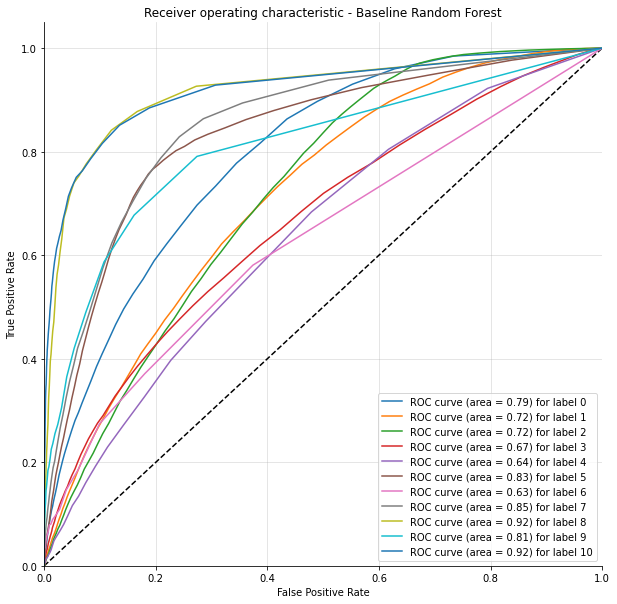

In [23]:
plot_multiclass_roc("Baseline Random Forest", y_test_dummies=y_test_oh.values, y_score=y_pred_p, n_classes=11, figsize=(10, 10))

## 6.3 Baseline Random Forest Model Classification Report

In [24]:
print(f"Baseline Random Forest: \n{metrics.classification_report(y_test, np.array(y_pred))}")

Baseline Random Forest: 
              precision    recall  f1-score   support

           0       0.34      0.18      0.24      4693
           1       0.40      0.47      0.43     15339
           2       0.42      0.58      0.49     17187
           3       0.36      0.26      0.30     10888
           4       0.12      0.01      0.02      2313
           5       0.40      0.48      0.44      6874
           6       0.41      0.03      0.05       558
           7       0.38      0.09      0.15      2037
           8       0.43      0.21      0.29       964
           9       0.50      0.07      0.13       564
          10       0.55      0.45      0.50      1342

    accuracy                           0.40     62759
   macro avg       0.39      0.26      0.27     62759
weighted avg       0.39      0.40      0.38     62759



### Conclusion: 
Since the ROC-AUC Score for the Baseline Random Forest Model is signficantly higher than the Dummy Classifier Baseline Model, the Null Hypothesis can be rejected in favor of Alternate Hypothesis -  Since the ROC-AUC score is more than 50%, the Random Forest model offers a better intuition to manage the hospital resources optimally and it justifies implementing this complex solution.

# 7. Hyper-Parameter Tuning of Baseline Random Forest Model

### The focus will be on optimizing ROC_AUC Metric, since Imbalanced Data problems, classification accuracy is not always the best performance metric
##### https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/

### 1. Are you predicting probabilities?
1.1. Do you need class labels?
        1.1.1 Is the positive class more important?
                Use Precision-Recall AUC
#### 1.2 Are all classes important?
#### *Use ROC AUC*

## 7.1 RandomizedSearchCV

In [25]:
## First Start with RandomGridSearchCV. Then based on that use GridSearchCV

from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 25, 5)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
class_weight = ["balanced", "balanced_subsample"] # weight the imbalanced classes within Stay_Days
# warm_start = [True, False] # Due to consideratons of computing resource limitations

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini'],
              "class_weight":class_weight
              }
print(random_grid)

{'n_estimators': [100, 125, 150, 175, 200], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 13, 17, 21, 25], 'min_samples_split': [2, 5, 6], 'min_samples_leaf': [1, 2, 4], 'criterion': ['entropy', 'gini'], 'class_weight': ['balanced', 'balanced_subsample']}


In [26]:
from sklearn.utils import parallel_backend
randomsearch_rf = RandomForestClassifier()
rf_randomcv = RandomizedSearchCV(estimator=randomsearch_rf,param_distributions=random_grid,n_iter=100,cv=3,verbose=0,
                               random_state=100,n_jobs=-1, error_score = -1, scoring="roc_auc_ovo_weighted") 
### fit the randomized model
with parallel_backend('threading', n_jobs=-1):
    rf_randomcvmodel = rf_randomcv.fit(X_train, y_train)

In [27]:
rf_randomcvmodel.best_params_

{'n_estimators': 200,
 'min_samples_split': 6,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 17,
 'criterion': 'gini',
 'class_weight': 'balanced'}

In [28]:
rf_randomcvmodel.best_score_

0.7938631790653038

In [29]:
rf_random_best_model = rf_randomcvmodel.best_estimator_
rf_random_best_model 

RandomForestClassifier(class_weight='balanced', max_depth=17,
                       max_features='log2', min_samples_leaf=4,
                       min_samples_split=6, n_estimators=200)

In [30]:
y_pred_rand = rf_randomcvmodel.best_estimator_.predict(X_test)
y_pred_rand_oh = pd.get_dummies(y_pred_rand)
y_test_oh = pd.get_dummies(y_test)
y_pred_rand_oh

,0,1,2,3,4,5,6,7,8,9,10
0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
62754,1,0,0,0,0,0,0,0,0,0,0
62755,0,0,1,0,0,0,0,0,0,0,0
62756,0,0,0,0,1,0,0,0,0,0,0
62757,0,1,0,0,0,0,0,0,0,0,0


In [31]:
y_pred_proba_rand = metrics.roc_auc_score(y_test, rf_randomcvmodel.best_estimator_.predict_proba(X_test), multi_class="ovo", average="weighted")
y_pred_proba_rand

0.796966184672124

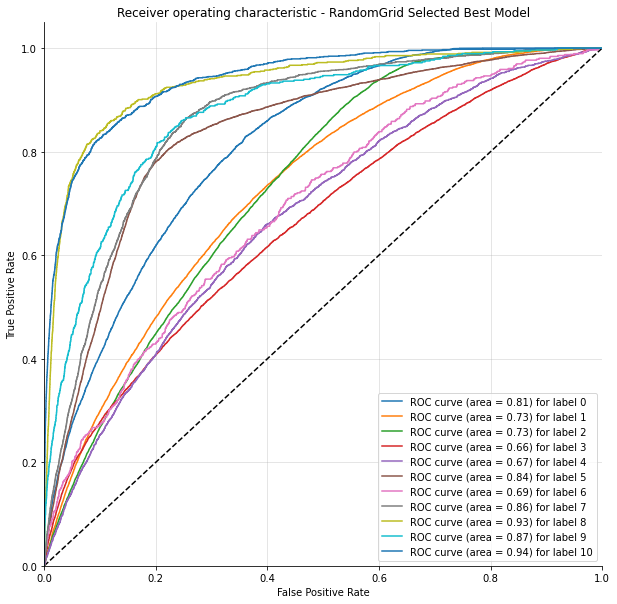

In [32]:
plot_multiclass_roc("RandomGrid Selected Best Model", y_test_dummies=y_test_oh.values, y_score=rf_randomcvmodel.best_estimator_.predict_proba(X_test), n_classes=11, figsize=(10, 10))

In [33]:
print(metrics.multilabel_confusion_matrix(y_test,y_pred_rand))

[[[50162  7904]
  [ 2364  2329]]

 [[38816  8604]
  [ 8946  6393]]

 [[37621  7951]
  [10242  6945]]

 [[50707  1164]
  [ 9907   981]]

 [[55747  4699]
  [ 1859   454]]

 [[50902  4983]
  [ 3858  3016]]

 [[61590   611]
  [  522    36]]

 [[58792  1930]
  [ 1611   426]]

 [[59968  1827]
  [  388   576]]

 [[61837   358]
  [  495    69]]

 [[60587   830]
  [  669   673]]]


In [34]:
print(metrics.classification_report(y_test, np.array(y_pred_rand)))

              precision    recall  f1-score   support

           0       0.23      0.50      0.31      4693
           1       0.43      0.42      0.42     15339
           2       0.47      0.40      0.43     17187
           3       0.46      0.09      0.15     10888
           4       0.09      0.20      0.12      2313
           5       0.38      0.44      0.41      6874
           6       0.06      0.06      0.06       558
           7       0.18      0.21      0.19      2037
           8       0.24      0.60      0.34       964
           9       0.16      0.12      0.14       564
          10       0.45      0.50      0.47      1342

    accuracy                           0.35     62759
   macro avg       0.28      0.32      0.28     62759
weighted avg       0.39      0.35      0.34     62759



## 7.2 GridSearchCV

Approach: Fine-tune model based on best parameters from RandomizedSearchCV 

In [35]:
## First Start with RandomGridSearchCV. Then based on that use GridSearchCV
from sklearn.model_selection import GridSearchCV

# Number of trees in random forest
n_estimators = [200, 210, 225]
# Number of features to consider at every split
max_features = ['sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(15, 20, 3)]
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [4,6,8]
# Create the random grid
class_weight = ["balanced"] # weight the imbalanced classes within Stay_Days
# warm_start = [True, False] # Due to consideratons of computing resource limitations

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
            #    'min_samples_leaf': min_samples_leaf,
              'criterion':['gini', "entropy"],
              "class_weight":class_weight,
              "bootstrap":[True],
              "oob_score":[True]}
print(param_grid)

{'n_estimators': [200, 210, 225], 'max_features': ['sqrt', 'log2'], 'max_depth': [15, 17, 20], 'min_samples_split': [2, 4, 6], 'criterion': ['gini', 'entropy'], 'class_weight': ['balanced'], 'bootstrap': [True], 'oob_score': [True]}


In [37]:
# HyperParameter Tuning for Random Forest Models
from sklearn.model_selection import GridSearchCV

rfclf = RandomForestClassifier()
grid_cv = GridSearchCV( estimator=rfclf,
                            param_grid = param_grid,
                            cv=3,
                            verbose=1,
                            n_jobs = 4,
                            error_score = -1,
                            scoring = "roc_auc_ovo_weighted")

In [38]:
with parallel_backend('threading', n_jobs=-1):
    rf_gridmodel = grid_cv.fit(X_train,y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


In [39]:
rf_gridmodel.best_params_

{'bootstrap': True,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 17,
 'max_features': 'sqrt',
 'min_samples_split': 6,
 'n_estimators': 225,
 'oob_score': True}

In [40]:
y_pred_proba_grid = metrics.roc_auc_score(y_test, rf_randomcvmodel.best_estimator_.predict_proba(X_test), multi_class="ovo", average="weighted")
y_pred_proba_rand

0.796966184672124

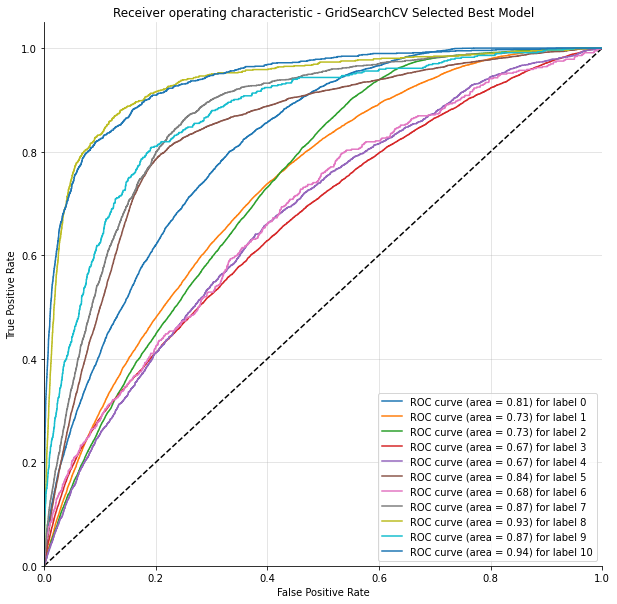

In [41]:
plot_multiclass_roc("GridSearchCV Selected Best Model", y_test_dummies=y_test_oh.values, y_score=rf_gridmodel.best_estimator_.predict_proba(X_test), n_classes=11, figsize=(10, 10))

In [42]:
y_pred_grid = rf_gridmodel.best_estimator_.predict(X_test)
print(metrics.classification_report(y_test, np.array(y_pred_grid)))

              precision    recall  f1-score   support

           0       0.24      0.48      0.32      4693
           1       0.42      0.42      0.42     15339
           2       0.46      0.42      0.44     17187
           3       0.45      0.11      0.17     10888
           4       0.09      0.18      0.12      2313
           5       0.37      0.46      0.41      6874
           6       0.06      0.06      0.06       558
           7       0.20      0.19      0.20      2037
           8       0.26      0.56      0.35       964
           9       0.19      0.10      0.13       564
          10       0.46      0.50      0.48      1342

    accuracy                           0.36     62759
   macro avg       0.29      0.32      0.28     62759
weighted avg       0.39      0.36      0.35     62759



In [43]:
rf_gridsearch_bestmodel = rf_gridmodel.best_estimator_
rf_gridsearch_bestmodel 

RandomForestClassifier(class_weight='balanced', max_depth=17,
                       max_features='sqrt', min_samples_split=6,
                       n_estimators=225, oob_score=True)

# 8. Checking Model Performance Impact by Balancing Imbalanced classes in Target Variable

Although Random Forest Algorithm is robust against Imbalanced data set, generating random forest model with balanced data set is checked for the given COVID-19 patient stay data set by addressing the Imbalanced Classes in the Target Variable

## 8.1. Undersampling Majority Classes
Balancing the data set by Undersampling the majority Classes with NearMiss function - select closest examples from majority class for each minority classes using 3 KNNs.


In [44]:
from imblearn.under_sampling import NearMiss

counter = Counter(y_train)
print(counter)
# define the undersampling method
undersample = NearMiss(version=3, n_neighbors=3) # NearMiss version=3 that selects the closest examples from the majority class for each minority class.
# transform the dataset
us_data_X, us_data_y = undersample.fit_resample(X_train, y_train)
# summarize the new class distribution
counter = Counter(us_data_y)
print(counter)

Counter({2: 69129, 1: 61756, 3: 43424, 5: 27589, 0: 18557, 4: 9228, 7: 8059, 10: 5206, 8: 3797, 9: 2149, 6: 2140})
Counter({0: 2140, 1: 2140, 2: 2140, 3: 2140, 4: 2140, 5: 2140, 6: 2140, 7: 2140, 8: 2140, 10: 2140, 9: 1954})


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:176: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"


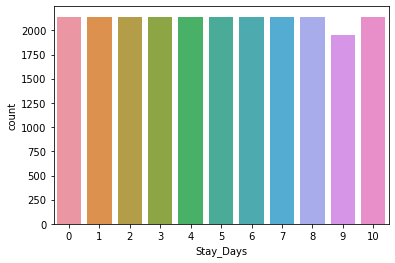

In [45]:
sns.countplot(us_data_y)

In [55]:
# Undersampled Training data Model with GridSearchCV best parameters

rf_us_clf = RandomForestClassifier(bootstrap=True, 
                                    class_weight = "balanced",
                                    criterion = "gini",
                                    max_depth  = 17, # Grid said 15, but since undersampled, creating full trees - Didnt make a difference in accuracy score
                                    max_features = "log2",
                                    min_samples_split = 6,
                                    n_estimators=210,
                                    oob_score = True,
                                    verbose=1, n_jobs=-1)

with parallel_backend("threading", n_jobs=-1):
    rf_us_model = rf_us_clf.fit(us_data_X, us_data_y) 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    1.2s finished


In [58]:
us_y_pred = rf_us_model.predict(X_test)
us_y_pred_oh = pd.get_dummies(us_y_pred)

# metrics.accuracy_score(y_test_oh, us_y_pred_oh)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.5s
[Parallel(n_jobs=6)]: Done 210 out of 210 | elapsed:    0.6s finished


In [57]:
print(metrics.classification_report(y_test, np.array(us_y_pred)))

              precision    recall  f1-score   support

           0       0.19      0.49      0.27      4693
           1       0.42      0.19      0.27     15339
           2       0.44      0.17      0.25     17187
           3       0.34      0.07      0.12     10888
           4       0.06      0.17      0.09      2313
           5       0.34      0.14      0.20      6874
           6       0.01      0.34      0.03       558
           7       0.12      0.15      0.13      2037
           8       0.18      0.63      0.29       964
           9       0.04      0.44      0.08       564
          10       0.45      0.45      0.45      1342

    accuracy                           0.20     62759
   macro avg       0.24      0.29      0.20     62759
weighted avg       0.35      0.20      0.22     62759



[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.5s
[Parallel(n_jobs=6)]: Done 210 out of 210 | elapsed:    0.6s finished


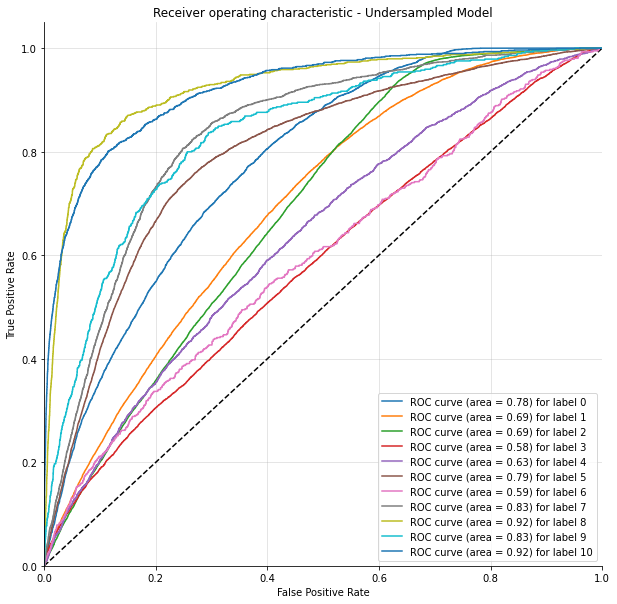

In [59]:
us_y_pred_proba = rf_us_model.predict_proba(X_test)
plot_multiclass_roc("Undersampled Model", y_test_dummies=y_test_oh.values, y_score=us_y_pred_proba, n_classes=11, figsize=(10, 10))

In [60]:
metrics.roc_auc_score(y_true=y_test, y_score=us_y_pred_proba, multi_class="ovo")

0.7727483547375021

## 8.2. Oversampling Minority Classes

Balancing the data set by Oversampling the minority Classes with SMOTE function - select closest examples from minority class for each majority classes using 3 KNNs. 

Oversampling Minority Classes using SMOTE - sampling_strategy=auto, k_neighbors=3


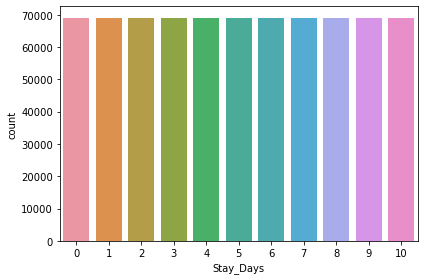

In [61]:
# Oversample data and then try to check the ROC-AUC score on predicted probabilities
from imblearn.over_sampling import SMOTE

print("Oversampling Minority Classes using SMOTE - sampling_strategy=auto, k_neighbors=3")
oversample = SMOTE(random_state=1, k_neighbors=3, sampling_strategy="auto")
os_data_X, os_data_y = oversample.fit_resample(X_train, y_train)

sns.countplot(os_data_y)
plt.tight_layout()

In [63]:
# Fitting the oversampled training set on RF classifier with GridSearchCV parameters

rf_os_clf = RandomForestClassifier(bootstrap=True, 
                                    class_weight = "balanced_subsample",
                                    criterion = "gini",
                                    max_depth  = 17, # Grid said 17, but since undersampled, tried with full trees - Didnt make a difference in accuracy score
                                    max_features = "log2",
                                    min_samples_split = 6,
                                    n_estimators=210,
                                    oob_score = True,
                                    verbose=1, n_jobs=-1)

In [64]:

with parallel_backend("threading", n_jobs=-1):
    rf_os_model = rf_os_clf.fit(os_data_X, os_data_y)  

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  1.3min finished


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.5s
[Parallel(n_jobs=6)]: Done 210 out of 210 | elapsed:    0.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.5s
[Parallel(n_jobs=6)]: Done 210 out of 210 | elapsed:    0.6s finished


0.19566914705460572
              precision    recall  f1-score   support

           0       0.19      0.49      0.27      4693
           1       0.42      0.19      0.27     15339
           2       0.44      0.17      0.25     17187
           3       0.34      0.07      0.12     10888
           4       0.06      0.17      0.09      2313
           5       0.34      0.14      0.20      6874
           6       0.01      0.34      0.03       558
           7       0.12      0.15      0.13      2037
           8       0.18      0.63      0.29       964
           9       0.04      0.44      0.08       564
          10       0.45      0.45      0.45      1342

    accuracy                           0.20     62759
   macro avg       0.24      0.29      0.20     62759
weighted avg       0.35      0.20      0.22     62759

0.09090909090909093
0.7727483547375021


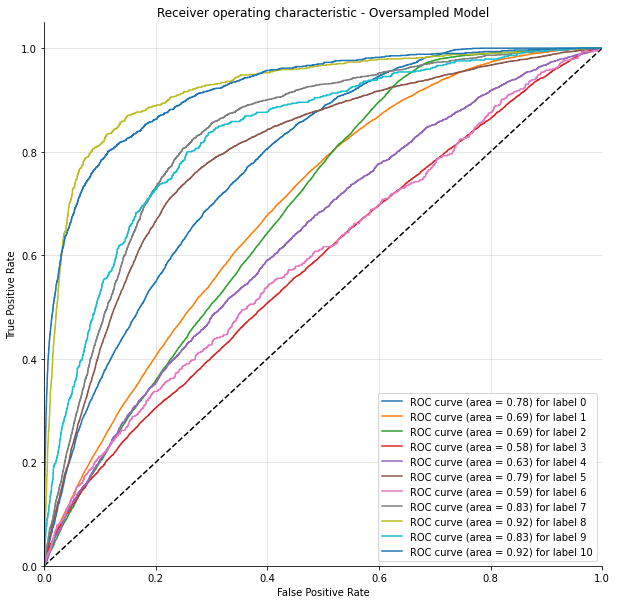

In [65]:
os_y_pred = rf_us_model.predict(X_test)
os_y_pred_oh = pd.get_dummies(us_y_pred)
os_y_pred_proba = rf_us_model.predict_proba(X_test)

print(metrics.accuracy_score(y_test_oh, os_y_pred_oh))

print(metrics.classification_report(y_test, np.array(os_y_pred)))


plot_multiclass_roc("Oversampled Model" ,y_test_dummies=y_test_oh.values, y_score=os_y_pred_proba, n_classes=11, figsize=(10, 10))
print(np.mean(os_y_pred_proba))
metrics.roc_auc_score(y_true=y_test, y_score=os_y_pred_proba, multi_class="ovo")
print(metrics.roc_auc_score(y_true=y_test, y_score=os_y_pred_proba, multi_class="ovo"))

# Model Performance Evaluation: RepeatedStratifiedKFold CrossValidation ROC-AUC scores for each of the models

## Choose model with Best ROC-AUC CrossValidation Scores between:
### 1. Dummy Classifier Model
### 2. Baseline Random Forest Classifier Model (Default Model Parameters)
### 3. RandomSearchCV Best Random Forest Classifier Model
### 4. GridSearchCV Best Random Forest Classifier Model
### 5. Undersampled Random Forest Classifier Model (GridSearchCV Best Parameters)
### 6. Oversample Random Forest Classifer Model (GridSearchCV Best Parameters)

(Scoring Method = ROC-AUC One-vs-One Weighted)

In [66]:
# Compare Model Performance with Cross Validation Scores
def cvscores(title, clf, X_test, y_test, scoring, cv):
    with parallel_backend('threading', n_jobs=-1):
        score_rocaucovow = cross_val_score(clf, X_test, y_test, scoring=scoring, cv=cv)
    print(f"Repeated Stratified Cross Validation Score for {title} is : {np.mean(score_rocaucovow) :.2%} \n")
    return score_rocaucovow

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=123)

print("Compare All Model Performance using RepeatedStratifiedKFold using Weighted ROC-AUC One vs One Scores: \n")
print("Perform 5 Splits and 10 Repeats: \n")

# dummy_clf rf_base rf_random_best_model rf_gridsearch_bestmodel rf_us_model rf_os_model
# 1. Dummy Baseline model
dummy_cv_score = cvscores(title="Dummy Baseline Model", 
            clf=dummy_clf, 
            X_test=X_test, 
            y_test=y_test, 
            scoring="roc_auc_ovo_weighted", 
            cv=cv)

# # 2. Original Baseline Random Forest model
rfbase_cv_score = cvscores(title="Baseline Random Forest Model", 
            clf=rf_base, 
            X_test=X_test, 
            y_test=y_test, 
            scoring="roc_auc_ovo_weighted", 
            cv=cv)

# #3. RandomSearchCV Best Model 
rand_cv_score = cvscores(title="RandomSearchCV Best Random Forest Model", 
            clf=rf_random_best_model, 
            X_test=X_test, 
            y_test=y_test, 
            scoring="roc_auc_ovo_weighted", 
            cv=cv)

# #3. GridSearchCV Best Model
grid_cv_score = cvscores(title="GridSearchCV Best Random Forest Model", 
            clf=rf_gridsearch_bestmodel, 
            X_test=X_test, 
            y_test=y_test, 
            scoring="roc_auc_ovo_weighted", 
            cv=cv)

# #4. Undersampled Majority Class with Best GridSearch Model Params
us_grid_cv_score = cvscores(title="Undersampled Majority - GridSearchCV Best Random Forest Model", 
            clf=rf_us_model, 
            X_test=X_test, 
            y_test=y_test, 
            scoring="roc_auc_ovo_weighted", 
            cv=cv)

# #5. Undersampled Majority Class with Best GridSearch Model Params
os_grid_cv_score = cvscores(title="Oversampled Minority - GridSearchCV Best Random Forest Model", 
            clf=rf_os_model, 
            X_test=X_test, 
            y_test=y_test, 
            scoring="roc_auc_ovo_weighted", 
            cv=cv)

Compare All Model Performance using RepeatedStratifiedKFold using Weighted ROC-AUC One vs One Scores: 

Perform 5 Splits and 10 Repeats: 

Repeated Stratified Cross Validation Score for Dummy Baseline Model is : 50.00% 

Repeated Stratified Cross Validation Score for Baseline Random Forest Model is : 75.20% 

Repeated Stratified Cross Validation Score for RandomSearchCV Best Random Forest Model is : 78.06% 

Repeated Stratified Cross Validation Score for GridSearchCV Best Random Forest Model is : 77.92% 

Repeated Stratified Cross Validation Score for Undersampled Majority - GridSearchCV Best Random Forest Model is : 77.90% 

Repeated Stratified Cross Validation Score for Oversampled Minority - GridSearchCV Best Random Forest Model is : 77.91% 



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    9.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    9.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    9.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    9.9s 

In [68]:
title="Dummy Baseline Model"
print(f"Repeated Stratified Cross Validation Score for {title} is : {np.mean(dummy_cv_score) :.2%} \n")

title="Baseline Random Forest Model"
print(f"Repeated Stratified Cross Validation Score for {title} is : {np.mean(rfbase_cv_score) :.2%} \n")

title="RandomSearchCV Selected Best Random Forest Model"
print(f"Repeated Stratified Cross Validation Score for {title} is : {np.mean(rand_cv_score) :.2%} \n")

title="GridSearchCV Selected Best Random Forest Model"
print(f"Repeated Stratified Cross Validation Score for {title} is : {np.mean(grid_cv_score) :.2%} \n")

title="Undersampled GridSearchCV Selected Best Random Forest Model"
print(f"Repeated Stratified Cross Validation Score for {title} is : {np.mean(us_grid_cv_score) :.2%} \n")

title="Oversampled GridSearchCV Selected Best Random Forest Model"
print(f"Repeated Stratified Cross Validation Score for {title} is : {np.mean(os_grid_cv_score) :.2%} \n")

# print(np.mean(dummy_cv_score),
# np.mean(rfbase_cv_score), 
# np.mean(rand_cv_score), 
# np.mean(grid_cv_score), 
# np.mean(us_grid_cv_score), 
# np.mean(os_grid_cv_score))

Repeated Stratified Cross Validation Score for Dummy Baseline Model is : 50.00% 

Repeated Stratified Cross Validation Score for Baseline Random Forest Model is : 75.20% 

Repeated Stratified Cross Validation Score for RandomSearchCV Selected Best Random Forest Model is : 78.06% 

Repeated Stratified Cross Validation Score for GridSearchCV Selected Best Random Forest Model is : 77.92% 

Repeated Stratified Cross Validation Score for Undersampled GridSearchCV Selected Best Random Forest Model is : 77.90% 

Repeated Stratified Cross Validation Score for Oversampled GridSearchCV Selected Best Random Forest Model is : 77.91% 



# Conclusion: Based on the Repeated Stratified K Fold Cross Validation, the best estimator from RandomSearchCV is the best model to generate the predictions based on the source dataset. 

No handles with labels found to put in legend.


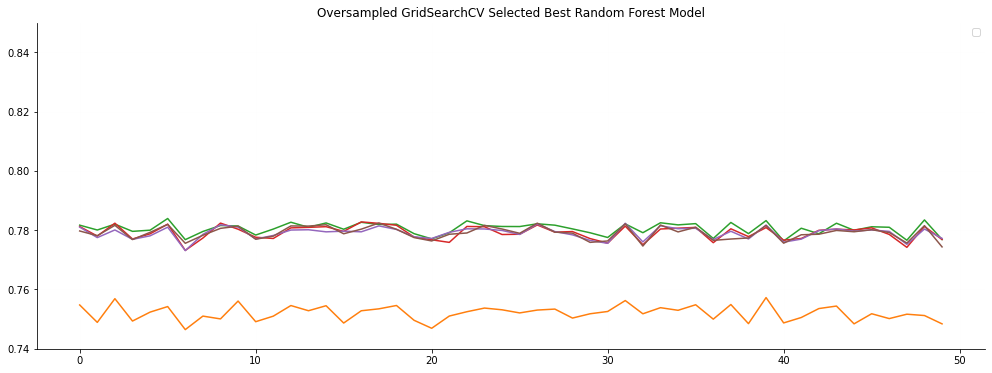

In [69]:
# Plotting the Cross Validation scores for the models 

fig, ax = plt.subplots(figsize=(17, 6))
# ax.plot([0.5, 0.5], [0.5, 0.5], 'k--')
# ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.74, 0.85])
# ax.set_xlabel('False Positive Rate')
# ax.set_ylabel('True Positive Rate')
ax.set_title(f'{title}')

ax.plot(dummy_cv_score)
ax.plot(rfbase_cv_score)
ax.plot(rand_cv_score)
ax.plot(grid_cv_score)
ax.plot(us_grid_cv_score)
ax.plot(os_grid_cv_score)

ax.legend(loc="best")
ax.grid(alpha=.010)
sns.despine()
plt.show()

# 9. Generate final predicted dataframe for the test dataset

In [85]:
# Final Predicted Probabilities on Validation Data set

final_y_pred_p = rf_random_best_model.predict_proba(X_test)
final_y_pred_p

array([[2.20968746e-02, 7.18349356e-02, 1.79442437e-02, ...,
        4.32756139e-02, 3.58864447e-02, 4.15031378e-02],
       [8.70347232e-03, 6.27866144e-02, 1.76701767e-02, ...,
        2.03888368e-01, 7.00500314e-02, 4.70844879e-02],
       [6.70306886e-03, 3.11081422e-02, 1.02502321e-02, ...,
        8.64036883e-02, 1.48788550e-01, 3.51312309e-02],
       ...,
       [5.24366408e-02, 9.06155170e-02, 2.47666118e-01, ...,
        6.34647845e-03, 1.06553527e-02, 8.67887132e-03],
       [6.97589661e-02, 3.24933082e-01, 2.41611682e-01, ...,
        2.78521758e-03, 6.24568550e-03, 3.87964695e-03],
       [3.26262839e-01, 1.99469189e-01, 2.60831392e-01, ...,
        5.26428593e-03, 3.01353594e-04, 2.21502295e-03]])

In [86]:
# Get max probabilities and class from predicted values
max_ypred_probs = []
max_ypred_probs = pd.DataFrame(final_y_pred_p).max(axis=1)
max_ypred_probs_df = pd.DataFrame({"Max_Prob":max_ypred_probs})
max_ypred_probs_df

max_ypred_class = []
max_ypred_class = pd.DataFrame(y_pred_p).idxmax(axis=1)
unique_Stay_Days = max_ypred_class.unique()
unique_Stay_Days

# ord_enc = OrdinalEncoder()
# le_encode = LabelEncoder()

# df = covid_df_raw.to_pandas_dataframe()

max_df = max_ypred_probs_df.merge(pd.DataFrame(max_ypred_class), left_index=True, right_index=True)
max_df = max_df.rename(columns={0:"Pred_Stay_Days_Class"})

In [87]:
final_df = X_test.reset_index().merge(max_df, left_index=True, right_index=True)
final_df.head()

,case_id,Hospital,Hospital_type,Hospital_city,Hospital_region,Extra_Rooms,Department,Ward_Type,Ward_Facility,Bed_Grade,patientid,City_Code_Patient,Admission_Type,Illness_Severity,Patient_Visitors,Age,Admission_Deposit,Max_Prob,Pred_Stay_Days_Class
0,68638,19,0,7,1,3,2,1,2,3,26544,8,0,2,5,4,3308.0,0.291994,3
1,82084,10,4,1,0,3,2,1,4,4,37995,8,0,1,6,1,4373.0,0.211461,3
2,18566,25,4,1,0,2,2,3,4,3,10102,8,0,2,4,6,4942.0,0.258690,3
3,242145,21,2,3,2,4,2,3,0,2,86421,9,1,1,2,4,3448.0,0.265244,2
4,19591,23,0,6,0,2,2,3,5,1,100190,2,0,0,4,8,4023.0,0.290193,5


In [92]:
def Stay_Days(i):
    switcher = {
                0: "0-10",
                1: "11-20",
                2: "21-30",
                3: "31-40",
                4: "41-50",
                5: "51-60",
                6: "61-70",
                7: "71-80",
                8: "81-90",
                9: "91-100",
                10: "More than 100 Days"
    }
    return switcher.get(i, "Invalid Target Class")

df = pd.DataFrame(columns={"Stay_Days_Pred"})
for i in final_df["Pred_Stay_Days_Class"].values:
   df = df.append({"Stay_Days_Pred": Stay_Days(i)}, ignore_index=True) 


In [103]:
final_df.merge(y_test, left_index=True, right_index=True)

,case_id,Hospital,Hospital_type,Hospital_city,Hospital_region,Extra_Rooms,Department,Ward_Type,Ward_Facility,Bed_Grade,patientid,City_Code_Patient,Admission_Type,Illness_Severity,Patient_Visitors,Age,Admission_Deposit,Max_Prob,Pred_Stay_Days_Class,Stay_Days
1,82084,10,4,1,0,3,2,1,4,4,37995,8,0,1,6,1,4373.0,0.211461,3,0
3,242145,21,2,3,2,4,2,3,0,2,86421,9,1,1,2,4,3448.0,0.265244,2,3
10,221614,21,2,3,2,2,2,3,0,2,60816,9,1,2,4,5,4472.0,0.280930,5,3
11,276211,11,1,2,1,3,2,1,3,3,109223,8,1,1,10,6,4258.0,0.411225,10,2
14,15471,17,4,1,0,4,2,2,4,4,124832,8,1,1,2,3,4855.0,0.382678,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62743,197066,26,1,2,1,4,2,2,3,3,6378,8,0,1,5,3,5525.0,0.253021,5,2
62745,282816,31,2,3,2,4,2,2,0,2,30085,21,0,1,2,2,4869.0,0.368243,1,2
62746,54749,11,1,2,1,4,3,1,3,3,77878,8,0,2,8,3,4685.0,0.220088,3,5
62747,315534,26,1,2,1,2,1,1,3,4,1212,3,0,2,6,5,3627.0,0.163167,5,0


# Perform Test of Association using Tukey Post-Hoc Analysis
## Between Length of Stay and Region 

Keep the overall Experiment Error Rate (EER) to 0.05 significance level 


In [108]:
import statsmodels.api as sm

y = covid_adj_df["Stay_Days"]
X = covid_adj_df["Hospital_region"]

stats_logitmodel = sm.MNLogit(y, X, missing="drop")
result = stats_logitmodel.fit()
print("Summary: \n",result.summary2())

Optimization terminated successfully.
         Current function value: 2.140971
         Iterations 7
Summary: 
                          Results: MNLogit
Model:              MNLogit          Pseudo R-squared: -0.128      
Dependent Variable: Stay_Days        AIC:              1343663.5370
Date:               2021-06-03 01:59 BIC:              1343770.1019
No. Observations:   313793           Log-Likelihood:   -6.7182e+05 
Df Model:           0                LL-Null:          -5.9533e+05 
Df Residuals:       313783           LLR p-value:      nan         
Converged:          1.0000           Scale:            1.0000      
No. Iterations:     7.0000                                         
-------------------------------------------------------------------
 Stay_Days = 0   Coef.   Std.Err.     t      P>|t|   [0.025  0.975]
-------------------------------------------------------------------
Hospital_region  0.7059    0.0068  103.7271  0.0000  0.6925  0.7192
-----------------------------

In [114]:
from pingouin import pairwise_tukey

pair_tukey = pairwise_tukey(data=covid_adj_df, dv="Stay_Days", between="Hospital_region", effsize="odds-ratio")

In [115]:
pair_tukey

,A,B,mean(A),mean(B),diff,se,T,p-tukey,odds-ratio
0,0,1,2.664030,2.714843,-0.050813,0.008565,-5.932406,0.001000,0.957996
1,0,2,2.664030,2.726737,-0.062707,0.010477,-5.985268,0.001000,0.948421
2,1,2,2.714843,2.726737,-0.011894,0.010612,-1.120805,0.502357,0.990006


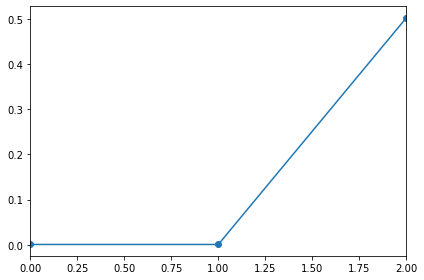

In [116]:
pair_tukey["p-tukey"].plot(kind="line", marker="o")
plt.tight_layout()